# NYC Taxi Fare Prediction

In [3]:
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sin, cos, sqrt, atan2, radians
import warnings
warnings.filterwarnings('ignore')

### Import and inspect 2017 (training) and 2018 (validation) data

In [25]:
# Old query without hasing
"""
    SELECT *
    FROM
        nyctaxi-284709.tlc_yellow_trips_{}.tlc_yellow_trips_{}
    WHERE
        RAND() < {}
"""

def import_yearly_data(year, sample_frac = .001):
    query = '''
    SELECT *
    FROM
        (
        SELECT 
            *,
            FARM_FINGERPRINT(CAST(tpep_pickup_datetime AS STRING)) AS hashrow
        FROM
            nyctaxi-284709.tlc_yellow_trips_{}.tlc_yellow_trips_{}
        )
        WHERE 
            ABS(MOD(hashrow, CAST(1/{} AS INT64))) = 1
    '''.format(year, year, sample_frac)
    df = bigquery.Client().query(query).to_dataframe()
    return df

In [26]:
df_train = import_yearly_data(2017)

In [27]:
df_train.shape

(114499, 18)

In [28]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hashrow
0,2,2017-11-22 23:26:14+00:00,2017-11-22 23:31:26+00:00,1,0.76,1,False,48,68,1,5.5,0.5,0.5,2.04,0.0,0.3,8.84,-5749264816973279001
1,2,2017-08-22 06:17:27+00:00,2017-08-22 06:47:55+00:00,2,9.04,1,False,142,61,2,29.0,0.0,0.5,0.00,0.0,0.3,29.80,-6425959103044865001
2,1,2017-10-17 12:56:35+00:00,2017-10-17 13:14:57+00:00,1,6.10,1,False,261,233,2,21.0,0.0,0.5,0.00,0.0,0.3,21.80,-4435072488875907001
3,2,2017-03-10 23:27:26+00:00,2017-03-10 23:43:50+00:00,1,2.81,1,False,229,68,1,12.5,0.5,0.5,2.76,0.0,0.3,16.56,1064880627168602001
4,2,2017-04-01 09:27:27+00:00,2017-04-01 09:39:57+00:00,1,2.13,1,False,237,239,1,10.5,0.0,0.5,2.26,0.0,0.3,13.56,-3464845081152330001


In [29]:
df_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hashrow
count,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,114499.000000,1.144990e+05
mean,1.548992,1.626145,2.917138,1.045878,162.945388,160.869781,1.335828,12.949597,0.330063,0.497425,1.832484,0.319082,0.299688,16.232434,2.818940e+16
std,0.497596,1.267449,3.746866,0.652552,66.665643,70.454118,0.491475,11.546301,0.455032,0.038218,2.532671,1.477023,0.012566,14.220551,5.333561e+18
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-85.000000,-1.000000,-0.500000,-1.000000,-5.760000,-0.300000,-85.800000,-9.223366e+18
25%,1.000000,1.000000,0.980000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.500000,-4.643330e+18
50%,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000,2.121284e+16
75%,2.000000,2.000000,3.000000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.360000,0.000000,0.300000,17.760000,4.665334e+18
max,2.000000,9.000000,124.300000,99.000000,265.000000,265.000000,4.000000,399.700000,4.500000,0.850000,68.000000,70.000000,0.300000,420.480000,9.222306e+18


In [30]:
df_val = import_yearly_data(2018)

In [31]:
df_val.shape

(102274, 18)

In [32]:
df_val.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hashrow
count,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,102274.000000,1.022740e+05
mean,1.592340,1.588615,2.930251,1.045965,163.112277,161.592976,1.314029,12.971810,0.336333,0.497145,1.866297,0.336568,0.299469,16.311021,7.163980e+16
std,0.521463,1.233440,3.758105,0.531790,66.427650,70.468710,0.484437,11.545201,0.465070,0.042030,2.508583,1.491612,0.016955,14.188186,5.307862e+18
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-76.000000,-4.500000,-0.500000,-2.430000,0.000000,-0.300000,-76.300000,-9.222369e+18
25%,1.000000,1.000000,0.970000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.580000,-4.538395e+18
50%,2.000000,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.400000,0.000000,0.300000,11.800000,8.829336e+16
75%,2.000000,2.000000,3.000000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000,4.653385e+18
max,4.000000,6.000000,89.000000,99.000000,265.000000,265.000000,4.000000,450.000000,4.500000,0.500000,100.000000,50.000000,0.300000,475.300000,9.223165e+18


### Import and Inspect Taxi Zone Geometry Data

In [33]:
def import_geom_data():
    query_geom = """
    SELECT *
    FROM
        nyctaxi-284709.taxi_zone_geom.taxi_zone_geom
    """
    df_geom = bigquery.Client().query(query_geom).to_dataframe()
    return df_geom

In [34]:
df_geom = import_geom_data()

In [35]:
df_geom.shape

(263, 4)

In [36]:
df_geom.head()

,zone_id,zone_name,borough,zone_geom
0,1,Newark Airport,EWR,"POLYGON((-74.1856319999999 40.6916479999999, -..."
1,3,Allerton/Pelham Gardens,Bronx,"POLYGON((-73.848596761 40.8716707849999, -73.8..."
2,18,Bedford Park,Bronx,"POLYGON((-73.8844286139999 40.8668003789999, -..."
3,20,Belmont,Bronx,"POLYGON((-73.8839239579998 40.8644177609999, -..."
4,31,Bronx Park,Bronx,"POLYGON((-73.8710017319999 40.8572767429999, -..."


In [37]:
df_geom.describe()

,zone_id,zone_name,borough,zone_geom
count,263,263,263,263
unique,260,260,6,263
top,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,MULTIPOLYGON(((-73.7470431634215 40.6375664264...
freq,3,3,69,1


## Clean and Preprocess Data

In [38]:
# helper functions for preprocessing 

# calculate average latitude and longitude of bounding polygon (found in df_geom)
def calculate_center(bounding_polygon):
    
    # remove everything but list of coords from input string
    if bounding_polygon[0] == 'P':
        polygon = bounding_polygon[len('POLYGON(('):-2]
        coords_list = polygon.split(', ')
        coords_list = [coords_list[i].split(' ') for i in range(len(coords_list))]
    elif bounding_polygon[0] == 'M':
        multi_polygon = bounding_polygon[len('MULTIPOLYGON((('):-3]
        polygon_list = multi_polygon.split(')), ((')
        coords_list = []
        for polygon in polygon_list: 
            coords_list_poly = polygon.split(', ')
            coords_list_poly = [coords_list_poly[i].split(' ') for i in range(len(coords_list_poly))]
            coords_list = coords_list + coords_list_poly
    
    L = len(coords_list)
    
    # extract lats and longs and take their average
    lats = [float(coords_list[i][0]) for i in range(len(coords_list))]
    longs = [float(coords_list[i][1]) for i in range(len(coords_list))]
    center = (sum(lats)/float(L), sum(longs)/float(L))
    
    return center

# calculate haversine distance - for small differences in lat/long, this is basically straightline distance - for given
# row, containing PU/DO lat/long. 
def haversine_distance(row):
    # approximate radius of earth in miles
    R = 3960
    
    PU = row['PU_zone_center']
    DO = row['DO_zone_center']
    
    lat1 = radians(PU[0])
    lon1 = radians(PU[1])
    lat2 = radians(DO[0])
    lon2 = radians(DO[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

# mean absolute percentage error
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# symmetric mean absolute percentage error
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


Write function to clean and preprocess, with focus on creating baseline model regressing total fare against straightline distance. 

In [39]:
def preprocess(df, df_geom):
    
    # calculate number of rows prior to cleaning for later comparison
    num_rows_init = df.shape[0]
    
    # add column for total fare, not including tip
    df['total_fare'] = df['fare_amount'] + df['tolls_amount']
    
    # visualize data prior to cleaning
    print('PLOTTING TOTAL FARE VS. TRIP DISTANCE PRIOR TO CLEANING ...')
    sns.set(font_scale=1.5)
    sns.jointplot(df['trip_distance'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
    plt.show()
    
    
    
    #remove distances and fares that are excessively small, and focus on prediction for standard ratecode, rather
    #than special rates (e.g. fixed rates to JFK, EWR, etc.). also exclude trips that are outliers with respect to 
    #ratio of total fare to trip distance.
    
    exclude_small_distances = df['trip_distance'] > .25
    exclude_large_distances = df['trip_distance'] < 50
    exclude_small_fares = (df['total_fare'] >= 3)
    exclude_nonstandard_ratecode = (df['RatecodeID'] == 1)
    exclude_small_faretodistance_ratio = (df['total_fare']/df['trip_distance'] > 2)

    df_cleaned = df[exclude_small_distances & exclude_large_distances & exclude_small_fares & exclude_nonstandard_ratecode & exclude_small_faretodistance_ratio]
    
    print('PLOTTING TOTAL FARE VS. TRIP DISTANCE AFTER REMOVAL OF EXTREME FARES AND DISTANCES ...')
    sns.jointplot(df_cleaned['trip_distance'], df_cleaned['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=100))
    plt.show()     
        
    # visualize average total fare vs total trip distance
    
    # bin in .25 mile intervals of distance
    distance_bins = [.25* i for i in range(int(50/.25))]
    df_cleaned['trip_distance_binned'] = pd.cut(df_cleaned['trip_distance'], distance_bins)
    # compute mean and std of total fare over trip distance bins, add them as new columns
    df_temp = df_cleaned[['trip_distance_binned', 'total_fare']].groupby('trip_distance_binned').agg({'total_fare': ['mean', 'std']})
    mean_std_dict = df_temp['total_fare'][['mean', 'std']].to_dict()
    df_cleaned['total_fare_binned_avg'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['mean'])
    df_cleaned['total_fare_binned_std'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['std'])
    
    print('PLOTTING AVG TOTAL FARE VS. TRIP DISTANCE ...')
    fig, ax = plt.subplots(figsize=(10,10))
    plt.errorbar(df_cleaned['trip_distance'], df_cleaned['total_fare_binned_avg'], yerr = df_cleaned['total_fare_binned_std'], fmt='o', color='blue',
                 ecolor='gray', elinewidth=2)
    plt.xlabel('trip_distance', fontsize=14)
    plt.ylabel('total_fare_binned_avg', fontsize=14)
    plt.title('Average Total Fare vs. Trip Distance', fontsize=16)
    plt.show()
    
    print('PLOTTING BEST FIT LINE FOR TOTAL FARE VS TRIP DISTANCE ...')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    sns.regplot(x = df_cleaned['trip_distance'], y = df_cleaned['total_fare'], scatter_kws={'alpha':0.15})
    plt.title('total_fare vs trip_distance', fontsize = 16)
    plt.show()

    
    
    # add columns with average and std of total fare over binned trip distance
    
    # bin in .25 mile intervals of distance
    distance_bins = [.25* i for i in range(int(50/.25))]
    df_cleaned['trip_distance_binned'] = pd.cut(df_cleaned['trip_distance'], distance_bins)

    # compute mean and std of total fare over trip distance bins, add them as new columns
    df_temp = df_cleaned[['trip_distance_binned', 'total_fare']].groupby('trip_distance_binned').agg({'total_fare': ['mean', 'std']})
    mean_std_dict = df_temp['total_fare'][['mean', 'std']].to_dict()
    df_cleaned['total_fare_binned_avg'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['mean'])
    df_cleaned['total_fare_binned_std'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['std'])

    
    
    # add columns from geometry dataframe, including pickup and dropoff latitude and longitude
    
    # calculate zone center by averaging lat/long over bounding polygon
    df_geom['zone_center'] = df_geom['zone_geom'].apply(calculate_center)
    
    # join zone_center to df_cleaned
    df_geom['zone_id'] = df_geom['zone_id'].astype(str).astype(int)
    df_cleaned = pd.merge(df_cleaned, df_geom, how = 'left', left_on = 'PULocationID', right_on = 'zone_id')
    df_cleaned = df_cleaned.rename(columns={"zone_id": "PU_zone_ID", "zone_name": "PU_zone_name", "borough": "PU_zone_borough", "zone_geom": "PU_zone_geom", "zone_center": "PU_zone_center"})
    df_cleaned = pd.merge(df_cleaned, df_geom, how = 'left', left_on = 'DOLocationID', right_on = 'zone_id')
    df_cleaned = df_cleaned.rename(columns={"zone_id": "DO_zone_ID", "zone_name": "DO_zone_name", "borough": "DO_zone_borough", "zone_geom": "DO_zone_geom", "zone_center": "DO_zone_center"})

    
    
    # remove rows with NA for PU or DO locations 
    
    shape_init = df_cleaned.shape
    df_cleaned = df_cleaned[df_cleaned['PU_zone_center'].notna() & df_cleaned['DO_zone_center'].notna()]
    df_cleaned = df_cleaned.reset_index()
    shape_new = df_cleaned.shape
    num_rows_removed = shape_init[0] - shape_new[0]
    print('num_rows_removed for na values in PU_zone_center and DO_zone_center columns: ' +str(num_rows_removed))

    
    
    # add column with geodesic/haversine - for our purposes, basically straightline - distance.
    
    df_cleaned['PU_DO_straightline_distance'] = df_cleaned.apply(lambda row: haversine_distance(row), axis=1)
    
    print('PLOTTING HISTOGRAM OF STRAIGHT LINE DISTANCES ...')
    df_cleaned['PU_DO_straightline_distance'].hist(bins=100, figsize=(10,10))
    plt.show()
    
    print('PLOTTING TOTAL FARE VS. STRAIGHT LINE DISTANCE ...')
    sns.jointplot(df_cleaned['PU_DO_straightline_distance'], df_cleaned['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=100))
    plt.show()
    
    print('PLOTTING BEST FIT LINE FOR TOTAL FARE VS STRAIGHT LINE DISTANCE ...')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    sns.regplot(x = df_cleaned['PU_DO_straightline_distance'], y = df_cleaned['total_fare'], scatter_kws={'alpha':0.15})
    plt.title('total_fare vs straightline_distance', fontsize = 16)
    plt.show()
    
    num_rows_final = df_cleaned.shape[0]
    
    print('')
    print('TOTAL NUMBER OF ROWS REMOVED: ' + str(num_rows_init - num_rows_final))
    
    return df_cleaned

### Preprocess 2017 (Training) Data

PLOTTING TOTAL FARE VS. TRIP DISTANCE PRIOR TO CLEANING ...


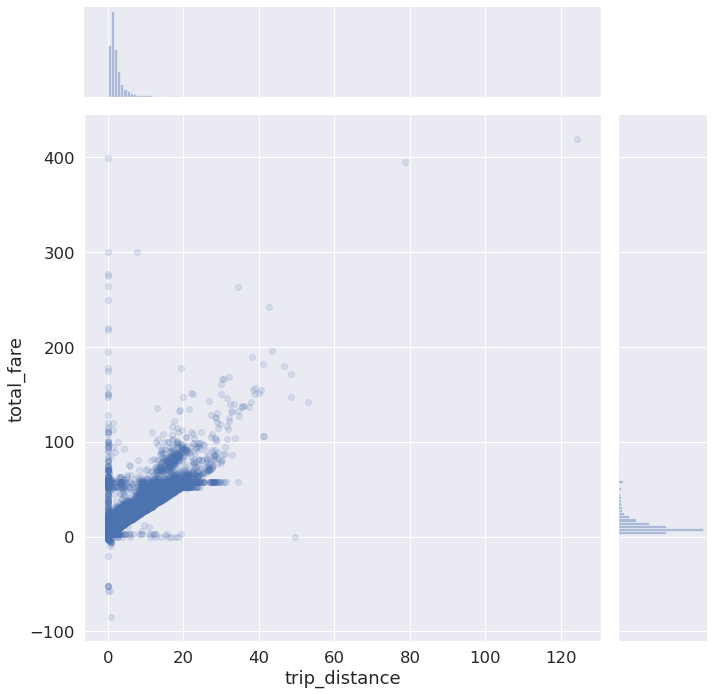

PLOTTING TOTAL FARE VS. TRIP DISTANCE AFTER REMOVAL OF EXTREME FARES AND DISTANCES ...


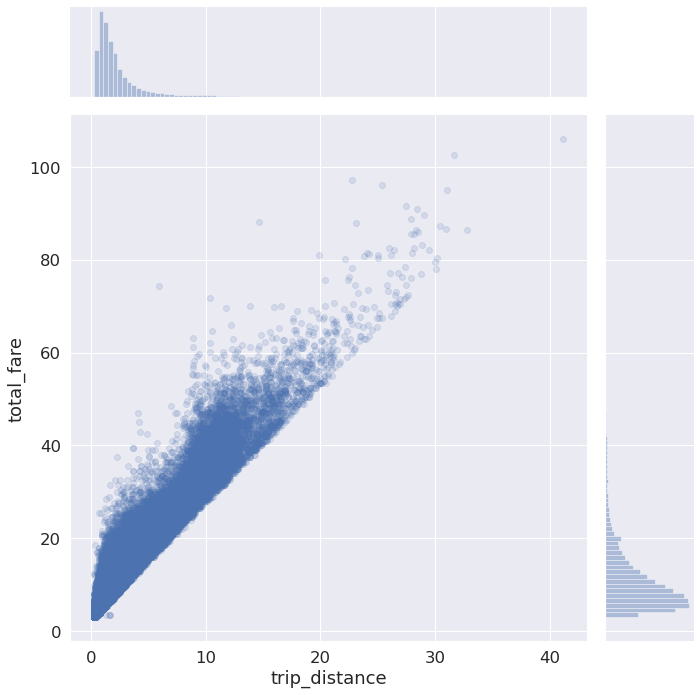

PLOTTING AVG TOTAL FARE VS. TRIP DISTANCE ...


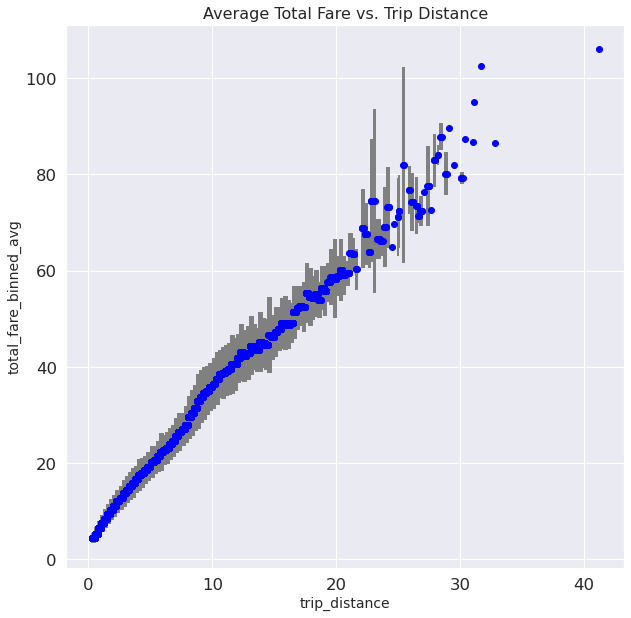

PLOTTING BEST FIT LINE FOR TOTAL FARE VS TRIP DISTANCE ...


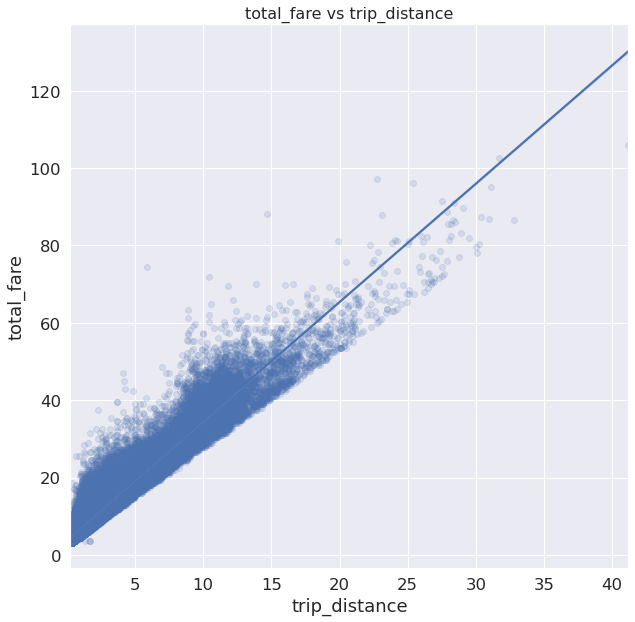

num_rows_removed for na values in PU_zone_center and DO_zone_center columns: 1616
PLOTTING HISTOGRAM OF STRAIGHT LINE DISTANCES ...


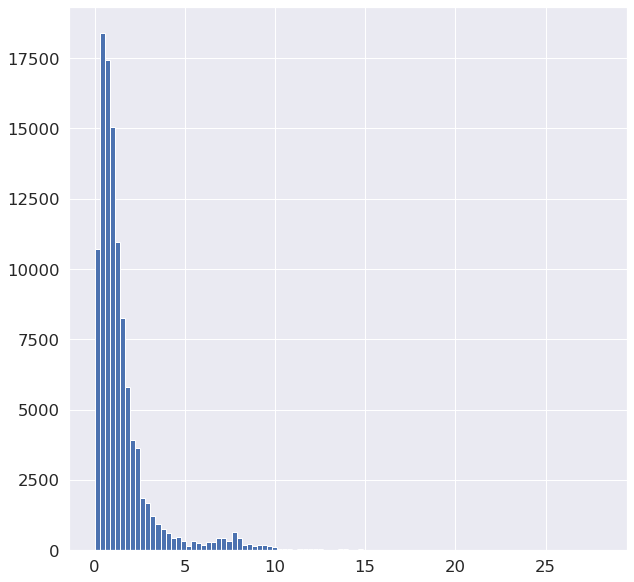

PLOTTING TOTAL FARE VS. STRAIGHT LINE DISTANCE ...


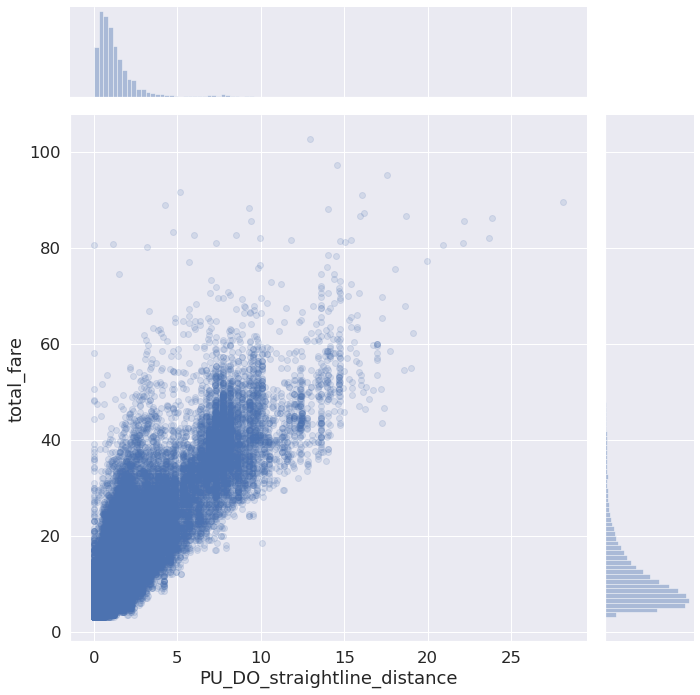

PLOTTING BEST FIT LINE FOR TOTAL FARE VS STRAIGHT LINE DISTANCE ...


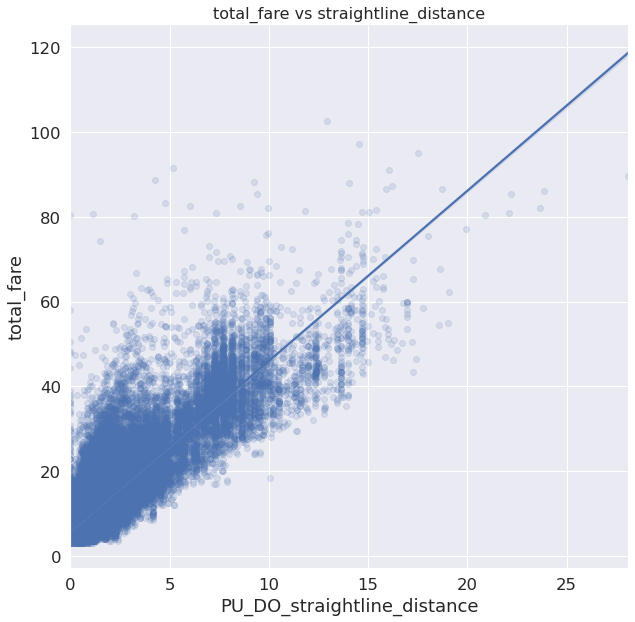


TOTAL NUMBER OF ROWS REMOVED: 6206


In [40]:
df_train = preprocess(df_train, df_geom)

In [41]:
df_train.shape

(108293, 34)

### Preprocess 2018 (Validation) Data

PLOTTING TOTAL FARE VS. TRIP DISTANCE PRIOR TO CLEANING ...


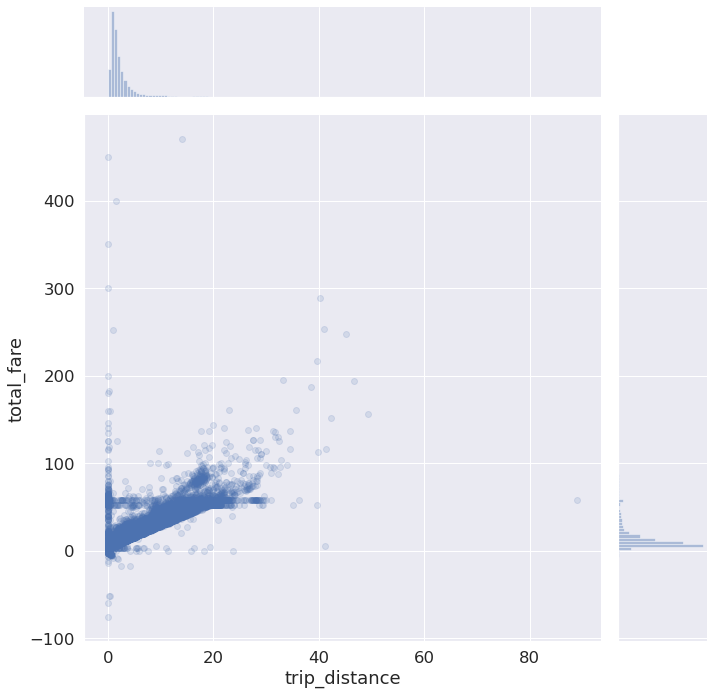

PLOTTING TOTAL FARE VS. TRIP DISTANCE AFTER REMOVAL OF EXTREME FARES AND DISTANCES ...


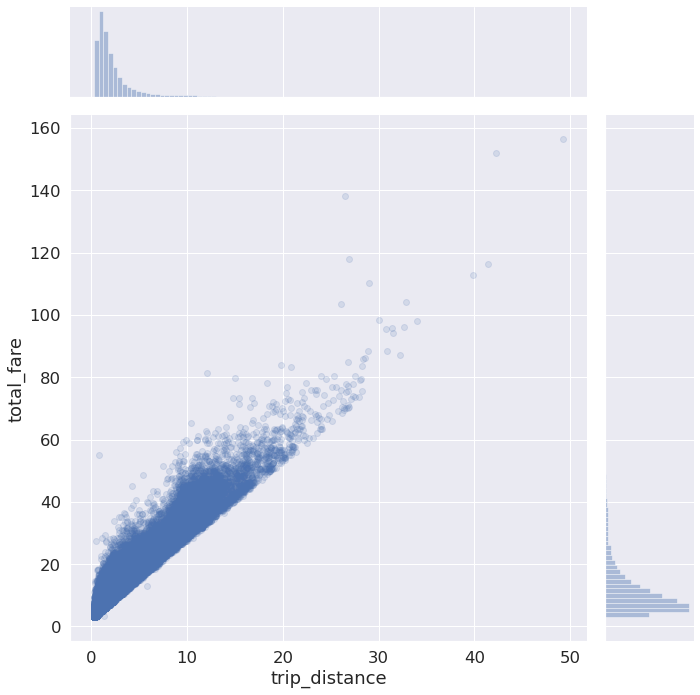

PLOTTING AVG TOTAL FARE VS. TRIP DISTANCE ...


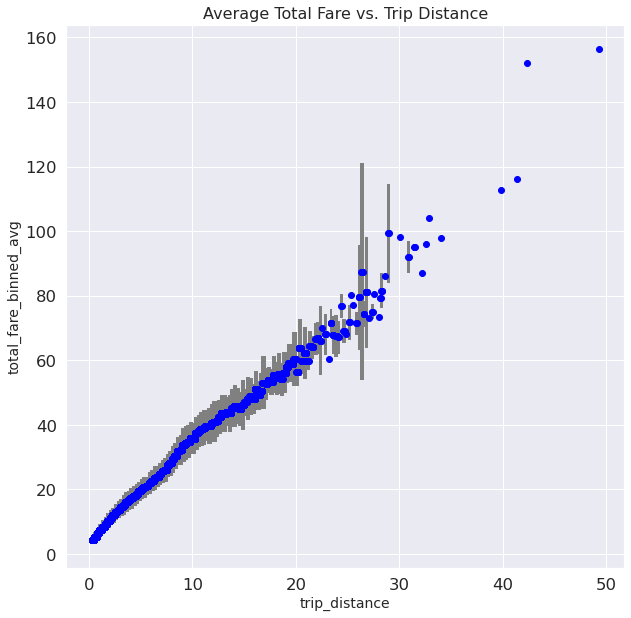

PLOTTING BEST FIT LINE FOR TOTAL FARE VS TRIP DISTANCE ...


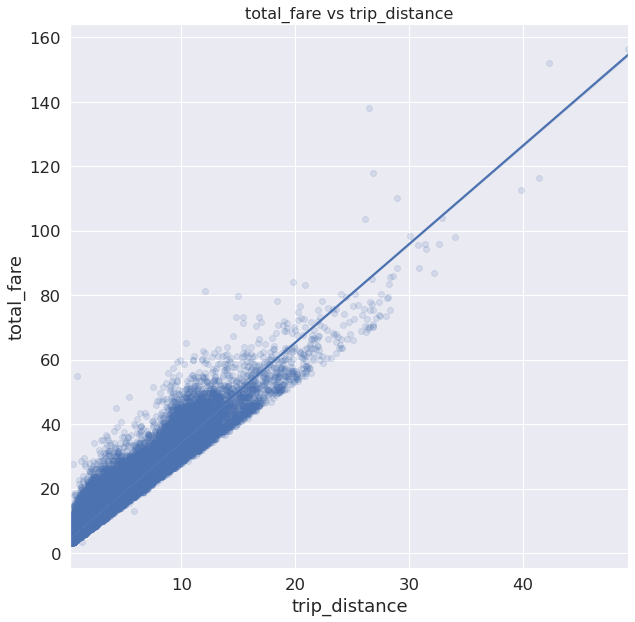

num_rows_removed for na values in PU_zone_center and DO_zone_center columns: 1544
PLOTTING HISTOGRAM OF STRAIGHT LINE DISTANCES ...


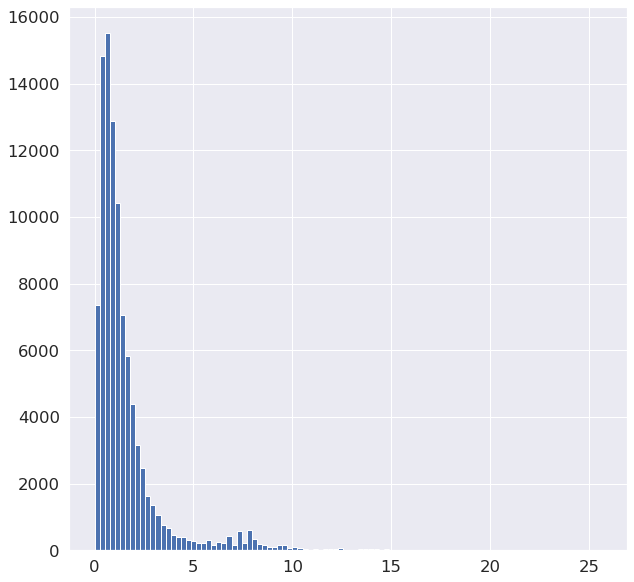

PLOTTING TOTAL FARE VS. STRAIGHT LINE DISTANCE ...


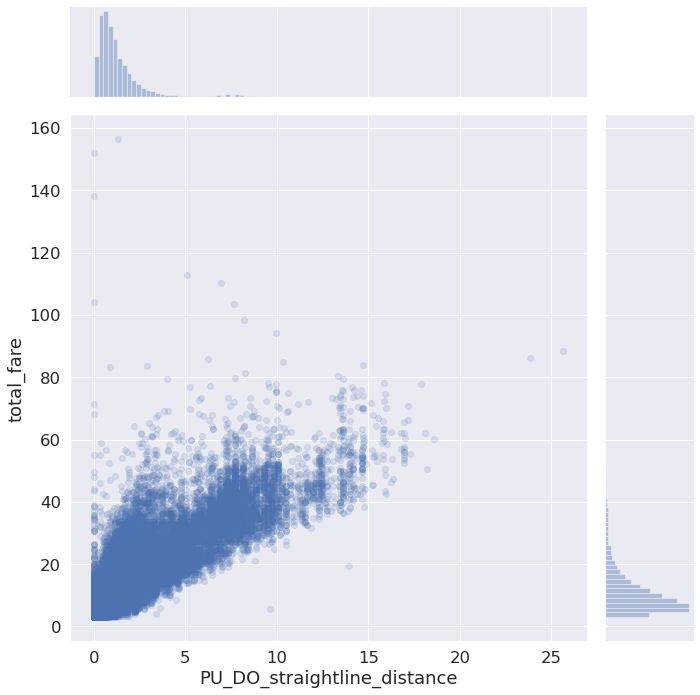

PLOTTING BEST FIT LINE FOR TOTAL FARE VS STRAIGHT LINE DISTANCE ...


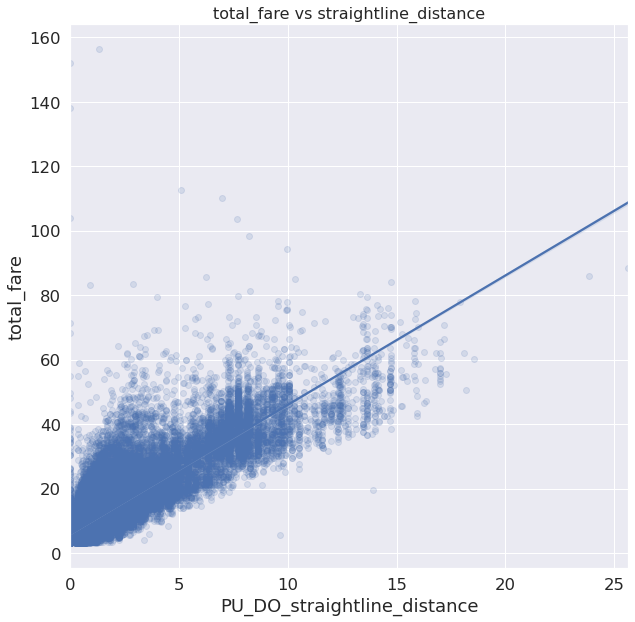


TOTAL NUMBER OF ROWS REMOVED: 5809


In [42]:
df_val = preprocess(df_val, df_geom)

## Train and Evaluate Baseline Linear Regression Model 

For a baseline model, perform simple linear regression of total fare against straight line distance. 

In [43]:
def train_evaluate_baseline_model(df_train, df_val):
    
    # train linear regression model and return statistics on train set
    
    X_train = df_train['PU_DO_straightline_distance'].values.reshape(-1,1)
    y_train = df_train['total_fare']

    linear_regression_model = LinearRegression().fit(X_train, y_train)

    train_rmse = mean_squared_error(linear_regression_model.predict(X_train), y_train, squared = False)
    print('train_rmse: ' + str(train_rmse))
    train_mape = mape(linear_regression_model.predict(X_train), y_train)
    print('train_mape: ' + str(train_mape))
    train_smape = smape(linear_regression_model.predict(X_train), y_train)
    print('train_smape: ' + str(train_smape))
    
    
    
    # evaluate on validation set 
    
    X_val = df_val['PU_DO_straightline_distance'].values.reshape(-1,1)
    y_val = df_val['total_fare']

    val_rmse = mean_squared_error(linear_regression_model.predict(X_val), y_val, squared = False)
    print('val_rmse: ' + str(val_rmse))
    val_mape = mape(linear_regression_model.predict(X_val), y_val)
    print('val_mape: ' + str(val_mape))
    val_smape = smape(linear_regression_model.predict(X_val), y_val)
    print('val_smape: ' + str(val_smape))

    
    return linear_regression_model, train_rmse, train_mape, train_smape, val_rmse, val_mape, val_smape

In [44]:
baseline_model, train_rmse, train_mape, train_smape, val_rmse, val_mape, val_smape \
= train_evaluate_baseline_model(df_train, df_val)

train_rmse: 4.771048471025553
train_mape: 29.342612135022065
train_smape: 28.93647176908166
val_rmse: 4.9247896996195
val_mape: 29.518521735287212
val_smape: 29.022120215267467


We want our final model to beat these values.